In [6]:
import numpy as np
import PIL
import os
import csv
import numpy.linalg as la
from PIL import Image
from xml.dom import minidom
from functions import *
import matplotlib.pyplot as plt

In [23]:
Anno_path = './VOC2012/Annotations/'
Img_path = './VOC2012/JPEGImages/'
test_path = './test_all/'

Create the list of the file names, and avoid running this cell repeatly.

In [8]:
file_list = list_files(Anno_path)

In [34]:
# classes = ["aeroplane","bicycle","bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", 
#            "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
# classes = ["aeroplane","bicycle","bird", "boat", "bus", "car", "cat", "chair", "cow", "dog", "horse", "motorbike", "person", 
#             "sheep", "sofa", "train", "tvmonitor"]
classes = ['car','person']

In [35]:
print(len(classes))

2


Stored tuple: (filename,name,pose,truncated,difficult,xmin,ymin,xmax,ymax)

In [222]:
for target_class in classes:
    obj_list = []
    N = len(file_list)
    # N = 1000
    for i in range(N):
        xml_file = Anno_path+file_list[i]
        dom = minidom.parse(xml_file)
        annotation = dom.documentElement
        filename = annotation.getElementsByTagName('filename')[0].firstChild.data
        size = annotation.getElementsByTagName('size')[0]
        width = size.getElementsByTagName('width')[0].firstChild.data
        height = size.getElementsByTagName('height')[0].firstChild.data
        depth = size.getElementsByTagName('depth')[0].firstChild.data
        objects = annotation.getElementsByTagName('object')
        for obj in objects:
            name = obj.getElementsByTagName('name')[0].firstChild.data
            if name != target_class:
                continue
            pose = obj.getElementsByTagName('pose')[0].firstChild.data
#             truncated = obj.getElementsByTagName('truncated')[0].firstChild.data
            difficult = obj.getElementsByTagName('difficult')[0].firstChild.data
            bndbox = obj.getElementsByTagName('bndbox')[0]
            xmin = bndbox.getElementsByTagName('xmin')[0].firstChild.data
            ymin = bndbox.getElementsByTagName('ymin')[0].firstChild.data
            xmax = bndbox.getElementsByTagName('xmax')[0].firstChild.data
            ymax = bndbox.getElementsByTagName('ymax')[0].firstChild.data
            obj = (filename,name,pose,difficult,xmin,ymin,xmax,ymax)
            obj_list.append(obj)
    storage_path = './eigenimage/{}/'.format(target_class)
    item_num = len(obj_list)
    print("The number of items meeting the standard is",item_num)
    tol_counter = 0
    Maxcount = 400
    for j in range(item_num):
        obj_name = obj_list[j][0]
        xmin,ymin,xmax,ymax = (obj_list[j][-4:])
        difficulty = obj_list[j][-5]
        if int(xmax)-int(xmin) < 150 or int(ymax)-int(ymin) < 150:
            continue
        elif int(difficulty) != 0:
            continue
    #     if obj_list[j][2] != 'Frontal':
    #         continue
        img_path = Img_path+obj_name
        image = Image.open(img_path)
        cropped_img = image.crop((int(xmin), int(ymin), int(xmax), int(ymax)))
        cropped_size = cropped_img.size
        new_size = (100, 100)
        resized_image = cropped_img.resize(new_size)
        image_path = storage_path+str(tol_counter)+'.jpg'
        resized_image.save(image_path)
        tol_counter+=1
        if tol_counter>=Maxcount:
            break
    print('We have created {} items'.format(tol_counter),'for class',target_class)

The number of items meeting the standard is 17401
We have created 400 items for class person


In [15]:
ave_dict = {}
basis_dict = {}
global_len = [169,226,297,111,27,259,299,400,232,116,89,400,244,294,400,80,125,115,141,170]

In [18]:
for i in range(len(classes)):
    input_class = classes[i]
    input_path = './eigenimage/{}/'.format(input_class)
    N = min(global_len[i],100)
    eigenclass = np.zeros((10000,N),dtype=float)
    ave_img = np.zeros((10000,),dtype=float)
    for k in range(N):
        img_path = input_path+str(k)+".jpg"
        image = Image.open(img_path)
        img = image.convert('L')
        img_npy = np.array(img)
        flt_img = img_npy.flatten()
        ave_img += flt_img
        eigenclass[:,k] = flt_img
    ave_img /= N
    for k in range(N):
        eigenclass[:,k] = eigenclass[:,k]-ave_img
    PCA_cov = np.dot(eigenclass.T,eigenclass)
    vals,vecs = la.eig(PCA_cov)
    index_list = np.argsort(-vals)
    num_vec = min(50,N//2)
    basis = vecs[:,index_list[:num_vec]]
    basiseigen = np.dot(eigenclass,basis)
    for i in range(num_vec):
        basiseigen[:,i] = basiseigen[:,i]/np.sum(basiseigen[:,i])
    ave_dict[input_class] = ave_img
    basis_dict[input_class] = basiseigen

In [27]:
basis_dict

{'aeroplane': array([[ 2.04845470e-04, -6.65054980e-04, -1.75163444e-04, ...,
         -3.61032885e-03,  1.12449830e-02,  2.56103609e-02],
        [ 2.07935178e-04, -6.32729323e-04, -1.85921864e-04, ...,
         -5.46617285e-03,  5.71813991e-03,  3.01117740e-02],
        [ 2.04345638e-04, -6.99354738e-04, -1.83442393e-04, ...,
         -5.15700219e-03,  7.69198506e-03,  2.22170750e-02],
        ...,
        [ 1.05059484e-04,  1.91225758e-03,  4.74099197e-05, ...,
         -6.03162857e-03, -1.80797005e-02,  9.73733026e-03],
        [ 1.03923144e-04,  1.88781867e-03,  6.43549234e-05, ...,
         -1.21567650e-02, -1.62419086e-02,  3.66773346e-02],
        [ 1.03532487e-04,  1.81294301e-03,  7.55753708e-05, ...,
         -1.44749150e-02, -1.77478510e-02,  3.15127829e-02]]),
 'bicycle': array([[ 9.69426172e-05,  8.57678618e-03,  3.39494577e-02, ...,
          1.42030514e-02, -3.74185751e-01, -1.13602392e-02],
        [ 9.59987787e-05,  7.74478990e-03,  3.01382636e-02, ...,
          2.20

In [22]:
# test_classes = ['aeroplane','bicycle','bus','car','person','train','boat','cat','horse','motorbike','dog']
test_classes = classes

In [21]:
for i in range(len(test_classes)):
    target_class = test_classes[i]
    obj_list = []
    N = len(file_list)
    # N = 1000
    for i in range(N):
        xml_file = Anno_path+file_list[i]
        dom = minidom.parse(xml_file)
    #     namelist = dom.getElementsByTagName('object')
    #     for book in namelist:
    #         print("Book ID:", book.getAttribute('name'))
    #     print(namelist)
        annotation = dom.documentElement
        filename = annotation.getElementsByTagName('filename')[0].firstChild.data
        size = annotation.getElementsByTagName('size')[0]
        width = size.getElementsByTagName('width')[0].firstChild.data
        height = size.getElementsByTagName('height')[0].firstChild.data
        depth = size.getElementsByTagName('depth')[0].firstChild.data
        objects = annotation.getElementsByTagName('object')
        for obj in objects:
            name = obj.getElementsByTagName('name')[0].firstChild.data
            if name != target_class:
                continue
            pose = obj.getElementsByTagName('pose')[0].firstChild.data
#             truncated = obj.getElementsByTagName('truncated')[0].firstChild.data
            difficult = obj.getElementsByTagName('difficult')[0].firstChild.data
            bndbox = obj.getElementsByTagName('bndbox')[0]
            xmin = bndbox.getElementsByTagName('xmin')[0].firstChild.data
            ymin = bndbox.getElementsByTagName('ymin')[0].firstChild.data
            xmax = bndbox.getElementsByTagName('xmax')[0].firstChild.data
            ymax = bndbox.getElementsByTagName('ymax')[0].firstChild.data
            obj = (filename,name,pose,difficult,xmin,ymin,xmax,ymax)
            obj_list.append(obj)
    storage_path = './test_all/{}/'.format(target_class)
    item_num = len(obj_list)
    print("The number of items meeting the standard is",item_num)
    tol_counter = 0
    Maxcount = 600
    for j in range(item_num-1,-1,-1):
        obj_name = obj_list[j][0]
        xmin,ymin,xmax,ymax = (obj_list[j][-4:])
        difficulty = obj_list[j][-5]
        if int(xmax)-int(xmin) < 100 or int(ymax)-int(ymin) < 100:
            continue
#         elif int(difficulty) != 0:
#             continue
    #     if obj_list[j][2] != 'Frontal':
    #         continue
        img_path = Img_path+obj_name
        image = Image.open(img_path)
        cropped_img = image.crop((int(xmin), int(ymin), int(xmax), int(ymax)))
        cropped_size = cropped_img.size
        new_size = (100, 100)
        resized_image = cropped_img.resize(new_size)
        image_path = storage_path+str(tol_counter)+'.jpg'
        resized_image.save(image_path)
        tol_counter+=1
        if tol_counter>=Maxcount:
            break
    print('We have created {} items'.format(tol_counter),'for class',target_class)

The number of items meeting the standard is 1002
We have created 560 items for class aeroplane
The number of items meeting the standard is 837
We have created 509 items for class bicycle
The number of items meeting the standard is 1271
We have created 600 items for class bird
The number of items meeting the standard is 1059
We have created 333 items for class boat
The number of items meeting the standard is 1561
We have created 212 items for class bottle
The number of items meeting the standard is 685
We have created 451 items for class bus
The number of items meeting the standard is 2492
We have created 600 items for class car
The number of items meeting the standard is 1277
We have created 600 items for class cat
The number of items meeting the standard is 3056
We have created 600 items for class chair
The number of items meeting the standard is 771
We have created 348 items for class cow
The number of items meeting the standard is 800
We have created 571 items for class diningtable


In [40]:
# # test_classes = ['aeroplane','bicycle','bus','car','person','train','boat','horse','motorbike']
test_classes = ['car','person','bus']

In [43]:
num_classes = len(test_classes)
comp_mat = np.zeros((num_classes,num_classes))
global_len = 3*[100]
# global_len = [560,509,600,333,212,451,600,600,600,348,571,600,577,568,600,333,367,600,530,408]
for i in range(num_classes):
    tar_class = test_classes[i]
    print("The target class is",tar_class)
    numb = global_len[i]
    for k in range(numb):
        image = Image.open(test_path+tar_class+'/'+str(k)+'.jpg')
        img = image.convert('L')
        image = np.array(img,dtype=float).flatten()
        min_loss = 100000000
        min_class = ''
        for j in range(num_classes):
            comp_class = test_classes[j]
            x = image-ave_dict[comp_class]
            basiseigen = basis_dict[comp_class]
            loss = la.norm(basiseigen@la.inv(basiseigen.T@basiseigen)@basiseigen.T@x-x)
            if loss<min_loss:
                min_loss = loss
                min_class = j
        comp_mat[i,min_class] += 1
        if k % 10 ==0 and k !=0:
            print("The accuracy so far is:",comp_mat[i,i]/k,"with samples",k,".")
    comp_mat[i,:]=comp_mat[i,:]/np.sum(comp_mat[i,:])
    print("Accuracy for target",test_classes[i],"is: ",comp_mat[i,i])

The target class is car
The accuracy so far is: 0.5 with samples 10 .
The accuracy so far is: 0.45 with samples 20 .
The accuracy so far is: 0.43333333333333335 with samples 30 .
The accuracy so far is: 0.425 with samples 40 .
The accuracy so far is: 0.4 with samples 50 .
The accuracy so far is: 0.4 with samples 60 .
The accuracy so far is: 0.4142857142857143 with samples 70 .
The accuracy so far is: 0.4 with samples 80 .
The accuracy so far is: 0.4 with samples 90 .
Accuracy for target car is:  0.39
The target class is person
The accuracy so far is: 0.8 with samples 10 .
The accuracy so far is: 0.85 with samples 20 .
The accuracy so far is: 0.8666666666666667 with samples 30 .
The accuracy so far is: 0.875 with samples 40 .
The accuracy so far is: 0.84 with samples 50 .
The accuracy so far is: 0.8333333333333334 with samples 60 .
The accuracy so far is: 0.8428571428571429 with samples 70 .
The accuracy so far is: 0.8625 with samples 80 .
The accuracy so far is: 0.8666666666666667 with

In [33]:
np.save('multi_comp_ALLL.npy',comp_mat)

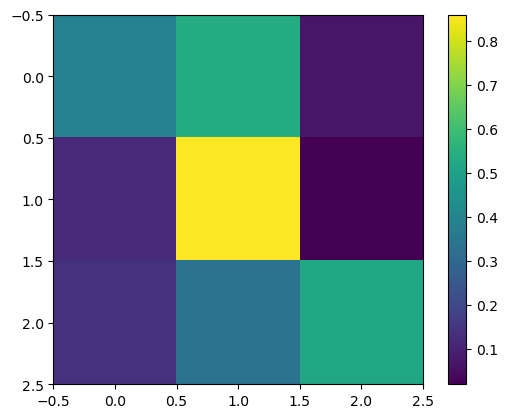

In [44]:
plt.imshow(comp_mat)
plt.colorbar()

In [207]:
with open("ave_dict.csv", "w", newline="") as file:
    writer = csv.writer(file)
    for key, value in ave_dict.items():
        writer.writerow([key, value])